In [1]:
import numpy as np
import random
import copy
import threading
import time
import os
import json
from collections import defaultdict
from queue import Queue

tasks = [
    "E", "Q", "G", "N", "F", "K", "M", "H", "I", "L", "S", "O", "B", "C", "P", "D", "J", "R", "A", "T"
]

edges = [
    ("E", "Q"), ("E", "G"), ("E", "N"), ("E", "A"), ("E", "C"), ("E", "R"), ("E", "S"), ("E", "D"), ("E", "B"), ("E", "O"), ("E", "K"), ("E", "P"), ("E", "I"), ("E", "T"), ("E", "J"), ("E", "F"), ("E", "H"),
    ("Q", "R"), ("Q", "J"), ("Q", "D"), ("Q", "T"), ("G", "N"), ("G", "T"), ("N", "R"), ("N", "L"), ("N", "D"), ("N", "K"), ("N", "M"), ("N", "P"), ("N", "F"), ("N", "S"), ("N", "O"), ("N", "H"), ("N", "A"),
    ("N", "C"), ("N", "B"), ("N", "J"), ("N", "I"), ("F", "D"), ("F", "T"), ("F", "C"), ("F", "A"), ("F", "S"), ("F", "J"), ("F", "H"), ("F", "K"), ("F", "O"), ("F", "I"), ("F", "P"), ("F", "M"), ("F", "L"),
    ("K", "T"), ("K", "H"), ("K", "L"), ("K", "A"), ("M", "I"), ("M", "L"), ("M", "P"), ("M", "B"), ("M", "H"), ("M", "D"), ("M", "C"), ("M", "O"), ("M", "T"), ("M", "A"), ("M", "S"), ("M", "R"), ("H", "C"),
    ("H", "B"), ("H", "S"), ("I", "P"), ("I", "A"), ("I", "T"), ("I", "S"), ("I", "J"), ("I", "O"), ("I", "L"), ("I", "C"), ("L", "J"), ("L", "A"), ("L", "D"), ("L", "C"), ("L", "S"), ("S", "R"), ("S", "T"),
    ("S", "A"), ("O", "C"), ("O", "P"), ("O", "A"), ("O", "B"), ("O", "J"), ("O", "R"), ("O", "T"), ("O", "D"), ("B", "A"), ("B", "R"), ("B", "T"), ("B", "P"), ("B", "D"), ("B", "C"), ("B", "J"), ("C", "D"),
    ("P", "T"), ("D", "J"), ("D", "R"), ("J", "R"), ("J", "T"), ("J", "A"), ("R", "A"), ("A", "T")
]

delays = {
    "E": 1, "Q": 5, "G": 5, "N": 0, "F": 0, "K": 2, "M": 2, "H": 5, "I": 3, "L": 1, "S": 5, "O": 4, "B": 4,
    "C": 2, "P": 2, "D": 5, "J": 2, "R": 5, "A": 2, "T": 5
}

In [ ]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [2]:
def topological_sort(tasks, edges):
    in_deg = {task: 0 for task in tasks}  # In-degree of each node
    adj_list = defaultdict(list)  # Adjacency list for each node
    
    for u, v in edges:
        adj_list[u].append(v)
        in_deg[v] += 1
    
    next_nodes = [node for node in tasks if in_deg[node] == 0]
    topological_order = []
    
    while next_nodes:
        # Randomly choose a node from the list
        current_node = random.choice(next_nodes)
        next_nodes.remove(current_node)
        topological_order.append(current_node)
        
        for neighbor in adj_list[current_node]:
            in_deg[neighbor] -= 1
            if in_deg[neighbor] == 0:
                next_nodes.append(neighbor)
    
    if len(topological_order) == len(tasks):
        return topological_order
    else:
        raise ValueError("Graph has a cycle, topological sort not possible.")

In [54]:
class Individual:
    def __init__(self, tasks, edges, delay):
        self.schedule = topological_sort(tasks,edges)
        self.fitness = self.calc_fitness(edges, delay)
        self.graph,self.predak = inicialize_graph(edges)

    #ako ne zadovoljava topsort fitness->inf inace izracunaj max(S)
    def calc_fitness(self, edges, delay):
        if not is_valid_schedule(self.schedule, edges):
            return float('-inf')
        graph, predak = inicialize_graph(edges)
        return -calculate_S(self.schedule, graph, delay, predak)[1]
    
    def invert(self):
        idx1, idx2 = random.sample(range(len(self.schedule)), 2)
        self.schedule[idx1], self.schedule[idx2] = self.schedule[idx2], self.schedule[idx1]
        return idx1, idx2
    
    def __lt__(self, other):
        return self.fitness < other.fitness

In [4]:
def is_valid_schedule(schedule, edges):
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [5]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for prec in predak[node]:
            max_S = max(S[node], S[prec] + delay[prec] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [55]:
def simulatedAnnealing(individual, edges, delay, iters=10000, initial_temp=1.0, alpha=0.99):
    #graph, predak = inicialize_graph(edges)
    best_individual = copy.deepcopy(individual)
    current_temp = initial_temp

    for _ in range(iters):
        original_schedule = copy.deepcopy(individual.schedule)
        original_fitness = individual.fitness
        
        # Perform a more substantial change (multi-step if necessary)
        idx1, idx2 = individual.invert()
        new_fitness = individual.calc_fitness(edges, delay)
        
        if new_fitness > individual.fitness:
            individual.fitness = new_fitness
        else:
            # Simulated annealing acceptance criteria
            delta_f = new_fitness - individual.fitness
            p = min(1.0, np.exp(delta_f / current_temp))
            q = random.uniform(0, 1)
            if p > q:
                individual.fitness = new_fitness
            else:
                # Revert to original schedule if the change isn't accepted
                individual.schedule = copy.deepcopy(original_schedule)
                individual.fitness = original_fitness
        
        # Update the best individual found
        if individual.fitness > best_individual.fitness:
            best_individual = copy.deepcopy(individual)
        
        # Gradually cool down
        current_temp *= alpha
    
    return best_individual

In [17]:
start_time = time.time()
schedule=Individual(tasks,edges,delays)
best_individual = simulatedAnnealing(schedule, edges, delays)
end_time = time.time()
time_taken = end_time - start_time

print(f'solution: {best_individual.schedule}, cost: {-best_individual.fitness}, time taken: {time_taken}')

solution: ['E', 'G', 'Q', 'N', 'F', 'M', 'I', 'O', 'K', 'H', 'L', 'B', 'S', 'C', 'D', 'P', 'J', 'R', 'A', 'T'], cost: 49, time taken: 0.15856695175170898


### Parallel

In [8]:
queue=Queue()

In [56]:
def thread_simulatedAnnealing(individual, edges, delay, iters=1000, initial_temp=1.0, alpha=0.99):
    start_time = time.time()
    #graph, predak = inicialize_graph(edges)
    best_individual = copy.deepcopy(individual)
    current_temp = initial_temp

    for _ in range(iters):
        original_schedule = copy.deepcopy(individual.schedule)
        original_fitness = individual.fitness
        
        # Perform a more substantial change (multi-step if necessary)
        idx1, idx2 = individual.invert()
        new_fitness = individual.calc_fitness(edges, delay)
        
        if new_fitness > individual.fitness:
            individual.fitness = new_fitness
        else:
            # Simulated annealing acceptance criteria
            delta_f = new_fitness - individual.fitness
            p = min(1.0, np.exp(delta_f / current_temp))
            q = random.uniform(0, 1)
            if p > q:
                individual.fitness = new_fitness
            else:
                # Revert to original schedule if the change isn't accepted
                individual.schedule = copy.deepcopy(original_schedule)
                individual.fitness = original_fitness
        
        # Update the best individual found
        if individual.fitness > best_individual.fitness:
            best_individual = copy.deepcopy(individual)
        
        # Gradually cool down
        current_temp *= alpha
    end_time = time.time()
    time_taken = end_time - start_time
    queue.put(best_individual)
    return best_individual

In [22]:
def parallel_SA(tasks,edges,delay):
    num_threads= 10
    threads= []
    for i in range(num_threads):
        threads.append(threading.Thread(target=thread_simulatedAnnealing,args=(Individual(tasks,edges,delays),edges,delays)))
        threads[i].start()
    best_schedules=set()
    for i in range(num_threads):
        threads[i].join()
        best_schedules.add(queue.get())
    for best_individual in best_schedules:
        print(f'solution: {best_individual.schedule}, cost: {-best_individual.fitness}')
    return best_schedules

In [24]:
parallel_SA(tasks,edges,delays)

solution: ['E', 'G', 'N', 'Q', 'F', 'M', 'I', 'K', 'H', 'O', 'L', 'S', 'B', 'C', 'P', 'D', 'J', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'N', 'F', 'Q', 'M', 'I', 'K', 'O', 'H', 'B', 'L', 'C', 'S', 'P', 'D', 'J', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'N', 'F', 'M', 'I', 'K', 'H', 'Q', 'O', 'L', 'B', 'C', 'P', 'D', 'J', 'S', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'Q', 'N', 'F', 'M', 'I', 'K', 'O', 'L', 'H', 'B', 'S', 'C', 'P', 'D', 'J', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'N', 'F', 'Q', 'M', 'K', 'I', 'O', 'L', 'H', 'S', 'B', 'C', 'P', 'D', 'J', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'Q', 'N', 'F', 'M', 'K', 'I', 'H', 'O', 'B', 'L', 'C', 'S', 'D', 'P', 'J', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'N', 'F', 'M', 'Q', 'K', 'I', 'O', 'H', 'L', 'S', 'B', 'C', 'D', 'J', 'R', 'A', 'P', 'T'], cost: 49
solution: ['E', 'G', 'Q', 'N', 'F', 'M', 'I', 'K', 'H', 'O', 'L', 'S', 'B', 'C', 'P', 'D', 'J', 'R', 'A', 'T'], cost: 49
solution: ['E', 'G', 'Q', 'N', '

{<__main__.Individual at 0x726100423610>,
 <__main__.Individual at 0x7261006329e0>}

In [74]:
def test_alg(path_to_test, path_to_results, alg, big_data=False): 
    files = os.listdir(path_to_test)
    data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
    
    data_files.sort()
    
    data_to_write = []

    for file_name in data_files:
        file_path = os.path.join(path_to_test, file_name)
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            tasks = loaded_data.get('tasks')
            edges = loaded_data.get('edges')
            delays = loaded_data.get('delays')
            
            best_individuals = []
            # Rough idea of best parameters after performing grid search
            if alg.__name__ == 'parallel_SA':
                best_individuals = parallel_SA(tasks, edges, delays)
            else:
                best_individual = simulatedAnnealing(Individual(tasks,edges,delays),
                                                             edges,
                                                             delays
                )
            
            if alg.__name__ == 'parallel_SA':
                print(f'Order: {best_individuals[0].schedule}, finish_time: {-best_individuals[0].fitness}')
                draw_graph(tasks, edges, delays, file_name[:-5] + "_graph", big_data)
                print("----------------------------------------------")
            else:
                print(f'Order: {best_individual.schedule}, finish_time: {-best_individual.fitness}')
                draw_graph(tasks, edges, delays, file_name[:-5] + "_graph", big_data)
                print("----------------------------------------------")
            data = dict()
            if alg.__name__ == 'parallel_SA':
                data = {
                    'test_name': file_name,
                    'order_of_tasks': best_individuals[:].schedule,
                    'finish_time': -best_individual[:].fitness#,
                    #'time_taken': best_individual.time_taken
                }
            else:
                data = {
                    'test_name': file_name,
                    'order_of_tasks': best_individual.schedule,
                    'finish_time': -best_individual.fitness#,
                    #'time_taken': best_individual.time_taken
                }
            data_to_write.append(data)
    
    save_results(path_to_results, data_to_write)

In [63]:
#!pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 1.6 MB/s eta 0:00:001.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.13-cp310-cp310-linux_x86_64.whl size=168496 sha256=4178e40fd918c79dd28446058a3c94549c5ccf2891ed7204114b0e11c53b61fc
  Stored in directory: /home/pavle/.cache/pip/wheels/c5/96/10/6c25add1fffc368b1927252bf73b63fcb938de8f4486e23691
Successfully built pygraphviz


In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import os
import json
import pygraphviz
def draw_graph(tasks, edges, delays, file_name, big_graphs=False, save_path='graphs/'):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    G.add_edges_from(edges)
    
    # Dynamic figure size based on the number of nodes
    num_nodes = len(tasks)
    if big_graphs:
        plt.figure(figsize=(12 + num_nodes * 0.2, 12 + num_nodes * 0.2))  # Adjust size dynamically
    else:
        plt.figure(figsize=(8, 8))  # Default size for small graphs
    
    pos = nx.spring_layout(G, k=0.5 if big_graphs else 0.8, iterations=50)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=10)
    
    # Clipping the delays directly below the nodes
    for node, (x, y) in pos.items():
        plt.annotate(f"Delay: {delays[node]}",
                     xy=(x, y), xytext=(0, -20),  # Position text 20 points below the node
                     textcoords='offset points', ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.5), fontsize=10, color='blue')

    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path)
    plt.show()

In [51]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

Order: ['B', 'A', 'E', 'C', 'D'], finish_time: 10


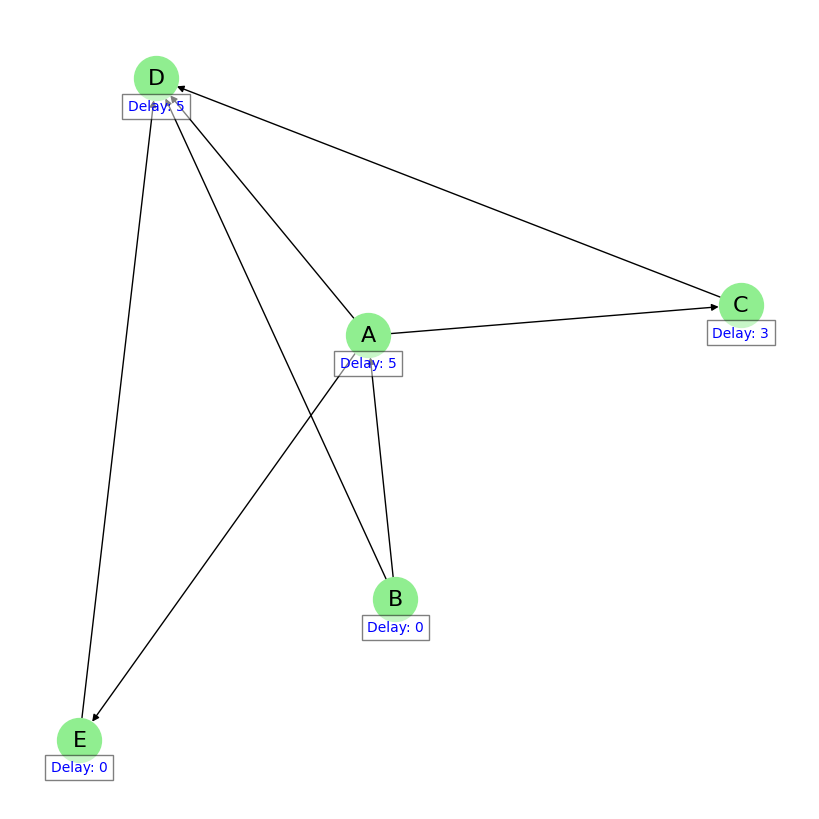

----------------------------------------------
Order: ['B', 'F', 'E', 'A', 'C', 'D'], finish_time: 13


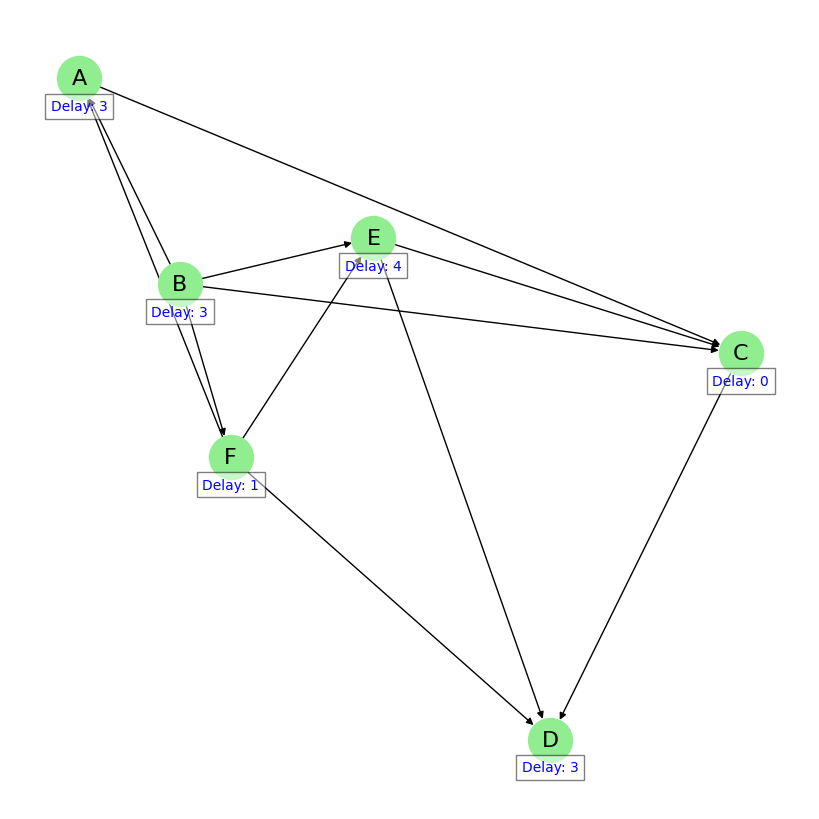

----------------------------------------------
Order: ['B', 'E', 'A', 'D', 'F', 'C', 'G'], finish_time: 16


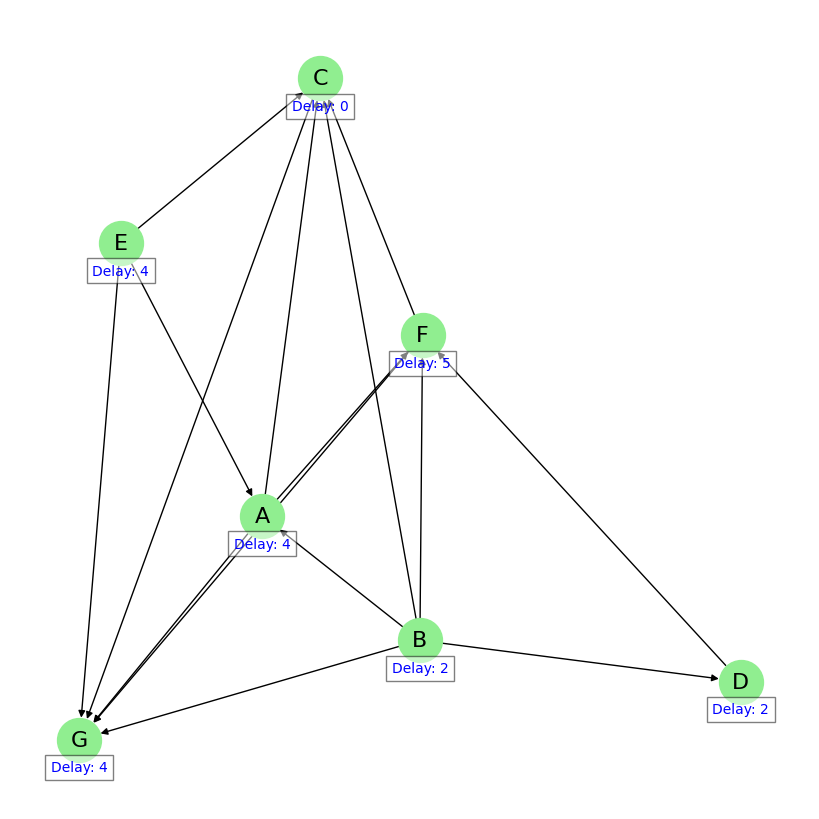

----------------------------------------------
Order: ['D', 'B', 'G', 'H', 'A', 'C', 'E', 'F'], finish_time: 14


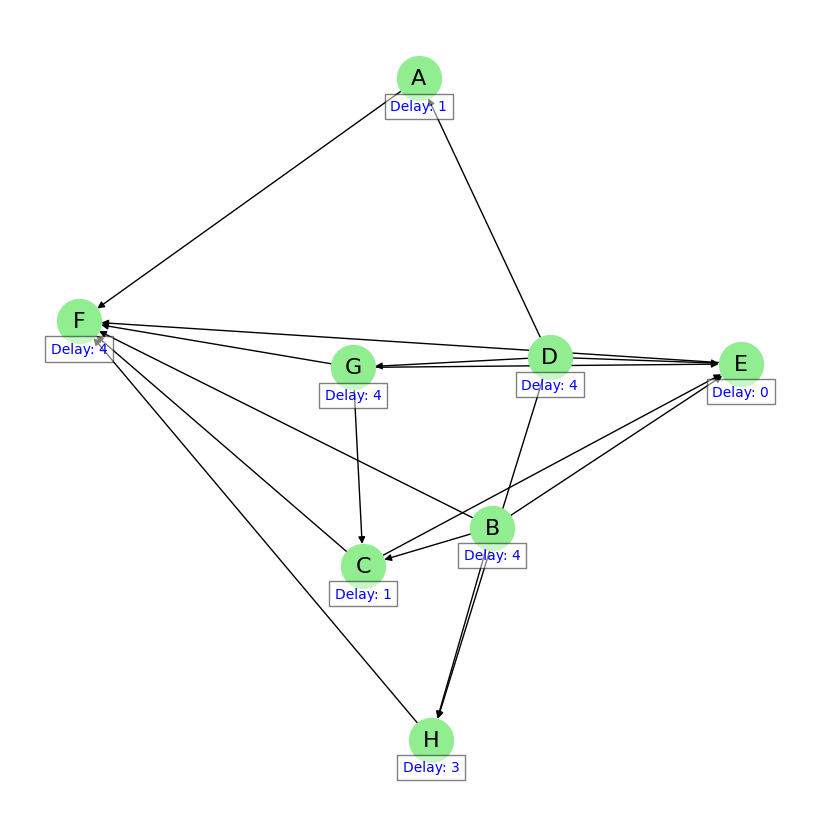

----------------------------------------------
Order: ['A', 'C', 'H', 'E', 'G', 'D', 'B', 'I', 'F'], finish_time: 11


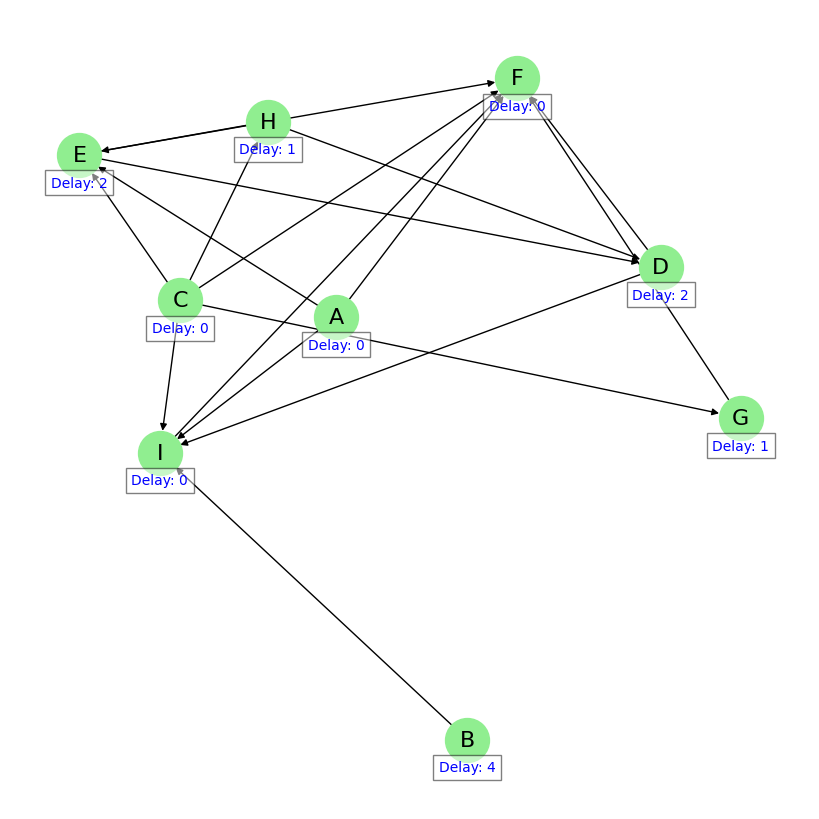

----------------------------------------------
Data saved to <_io.TextIOWrapper name='/home/pavle/Desktop/RI/RI_projekat/MPCSD/results/small_data/SA.json' mode='w' encoding='UTF-8'>


In [76]:
test_file = '/home/pavle/Desktop/RI/RI_projekat/MPCSD/test_files/small_data/'
result_file = '/home/pavle/Desktop/RI/RI_projekat/MPCSD/results/small_data/SA.json'
test_alg(test_file, result_file, simulatedAnnealing, False)

Order: ['E', 'G', 'N', 'F', 'M', 'K', 'I', 'O', 'H', 'B', 'L', 'C', 'S', 'P', 'Q', 'D', 'J', 'R', 'A', 'T'], finish_time: 49


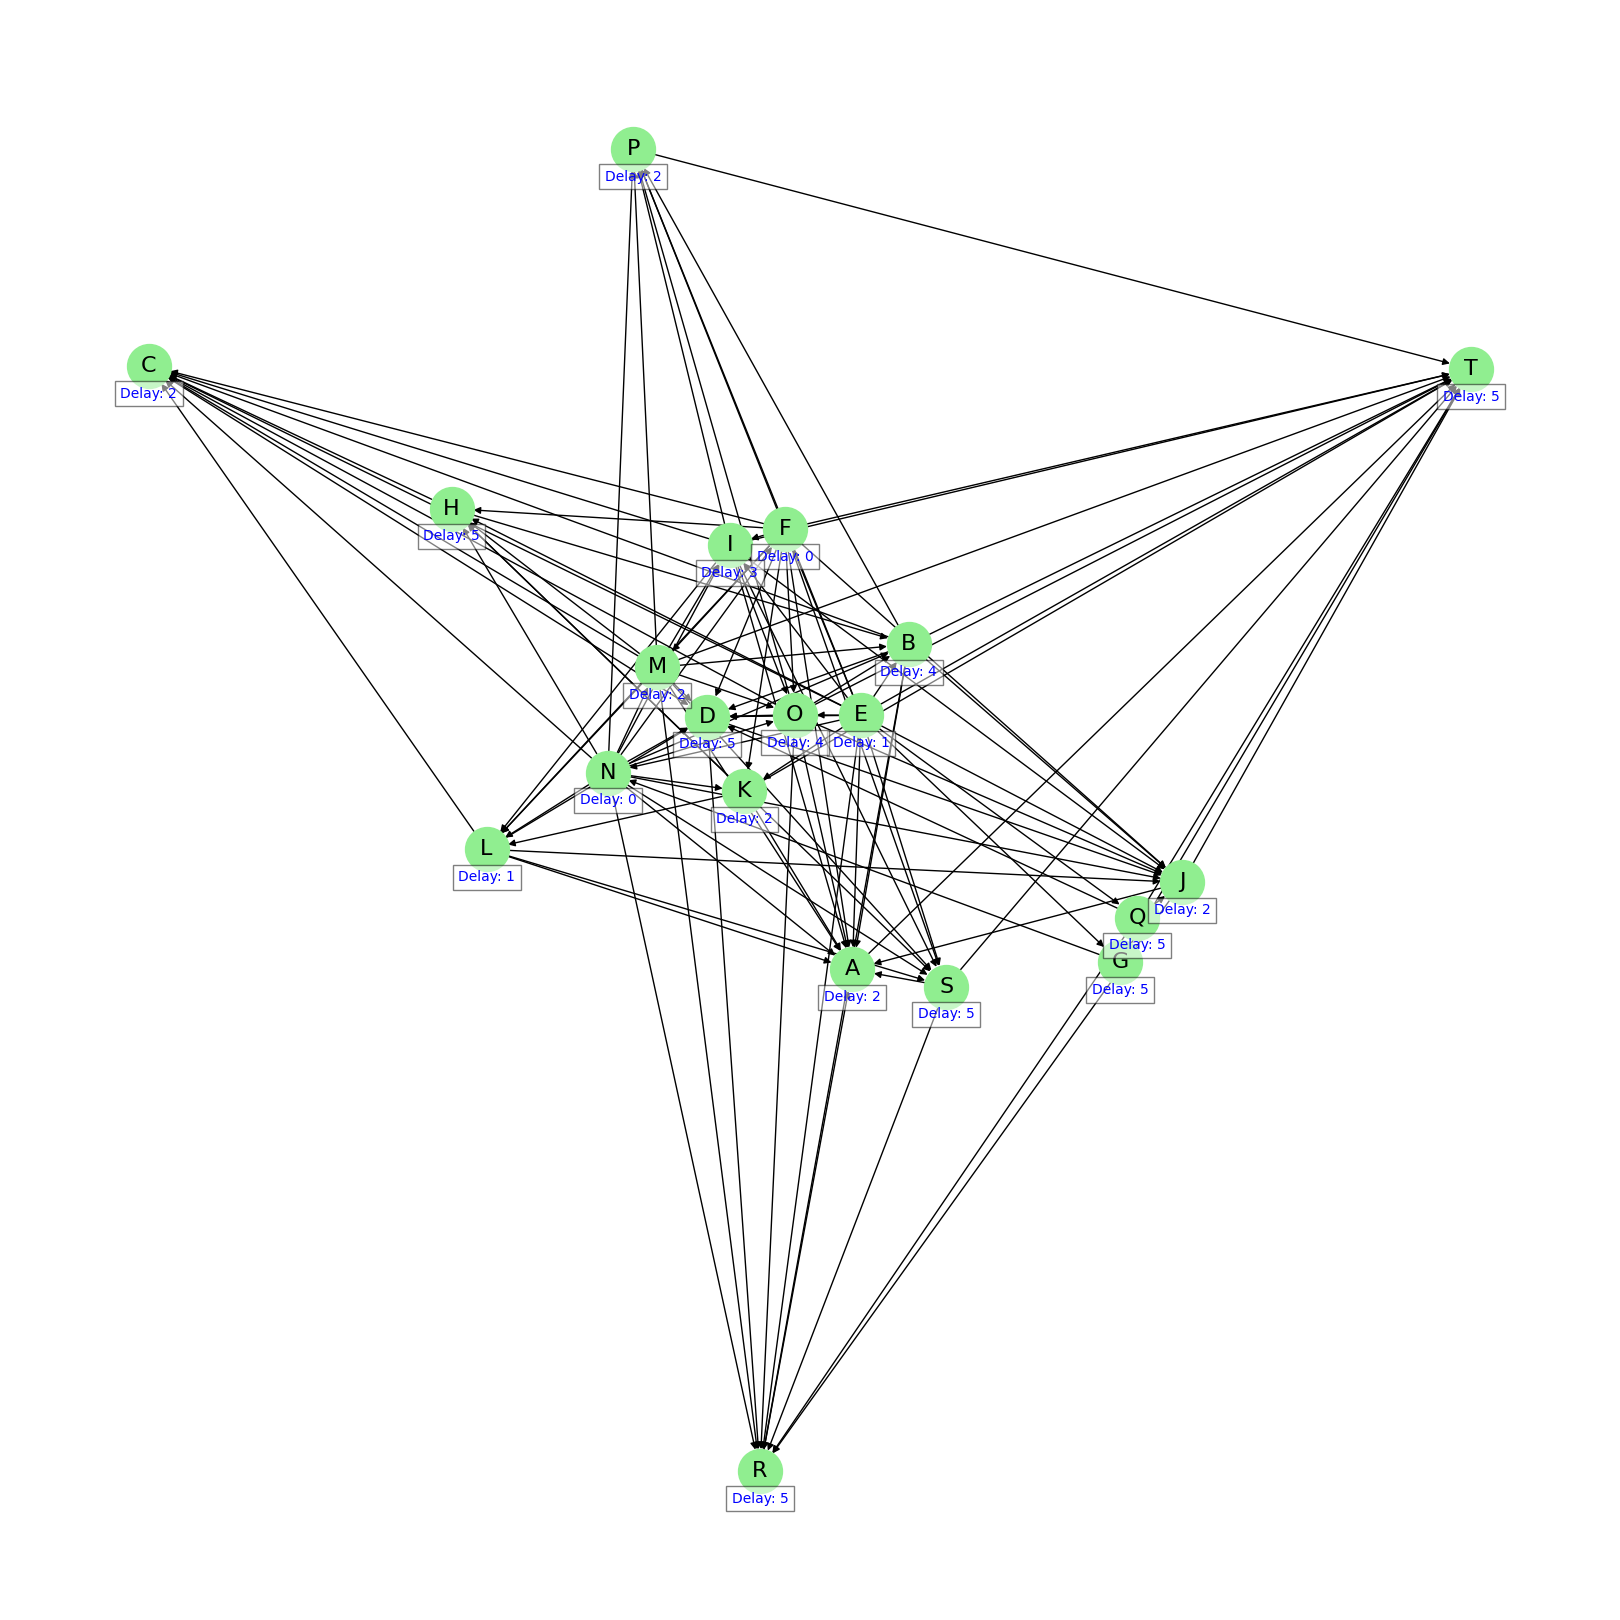

----------------------------------------------
Order: ['B', 'G', 'P', 'K', 'T', 'Q', 'M', 'I', 'A', 'H', 'C', 'S', 'D', 'R', 'J', 'O', 'F', 'N', 'U', 'L', 'E'], finish_time: 41


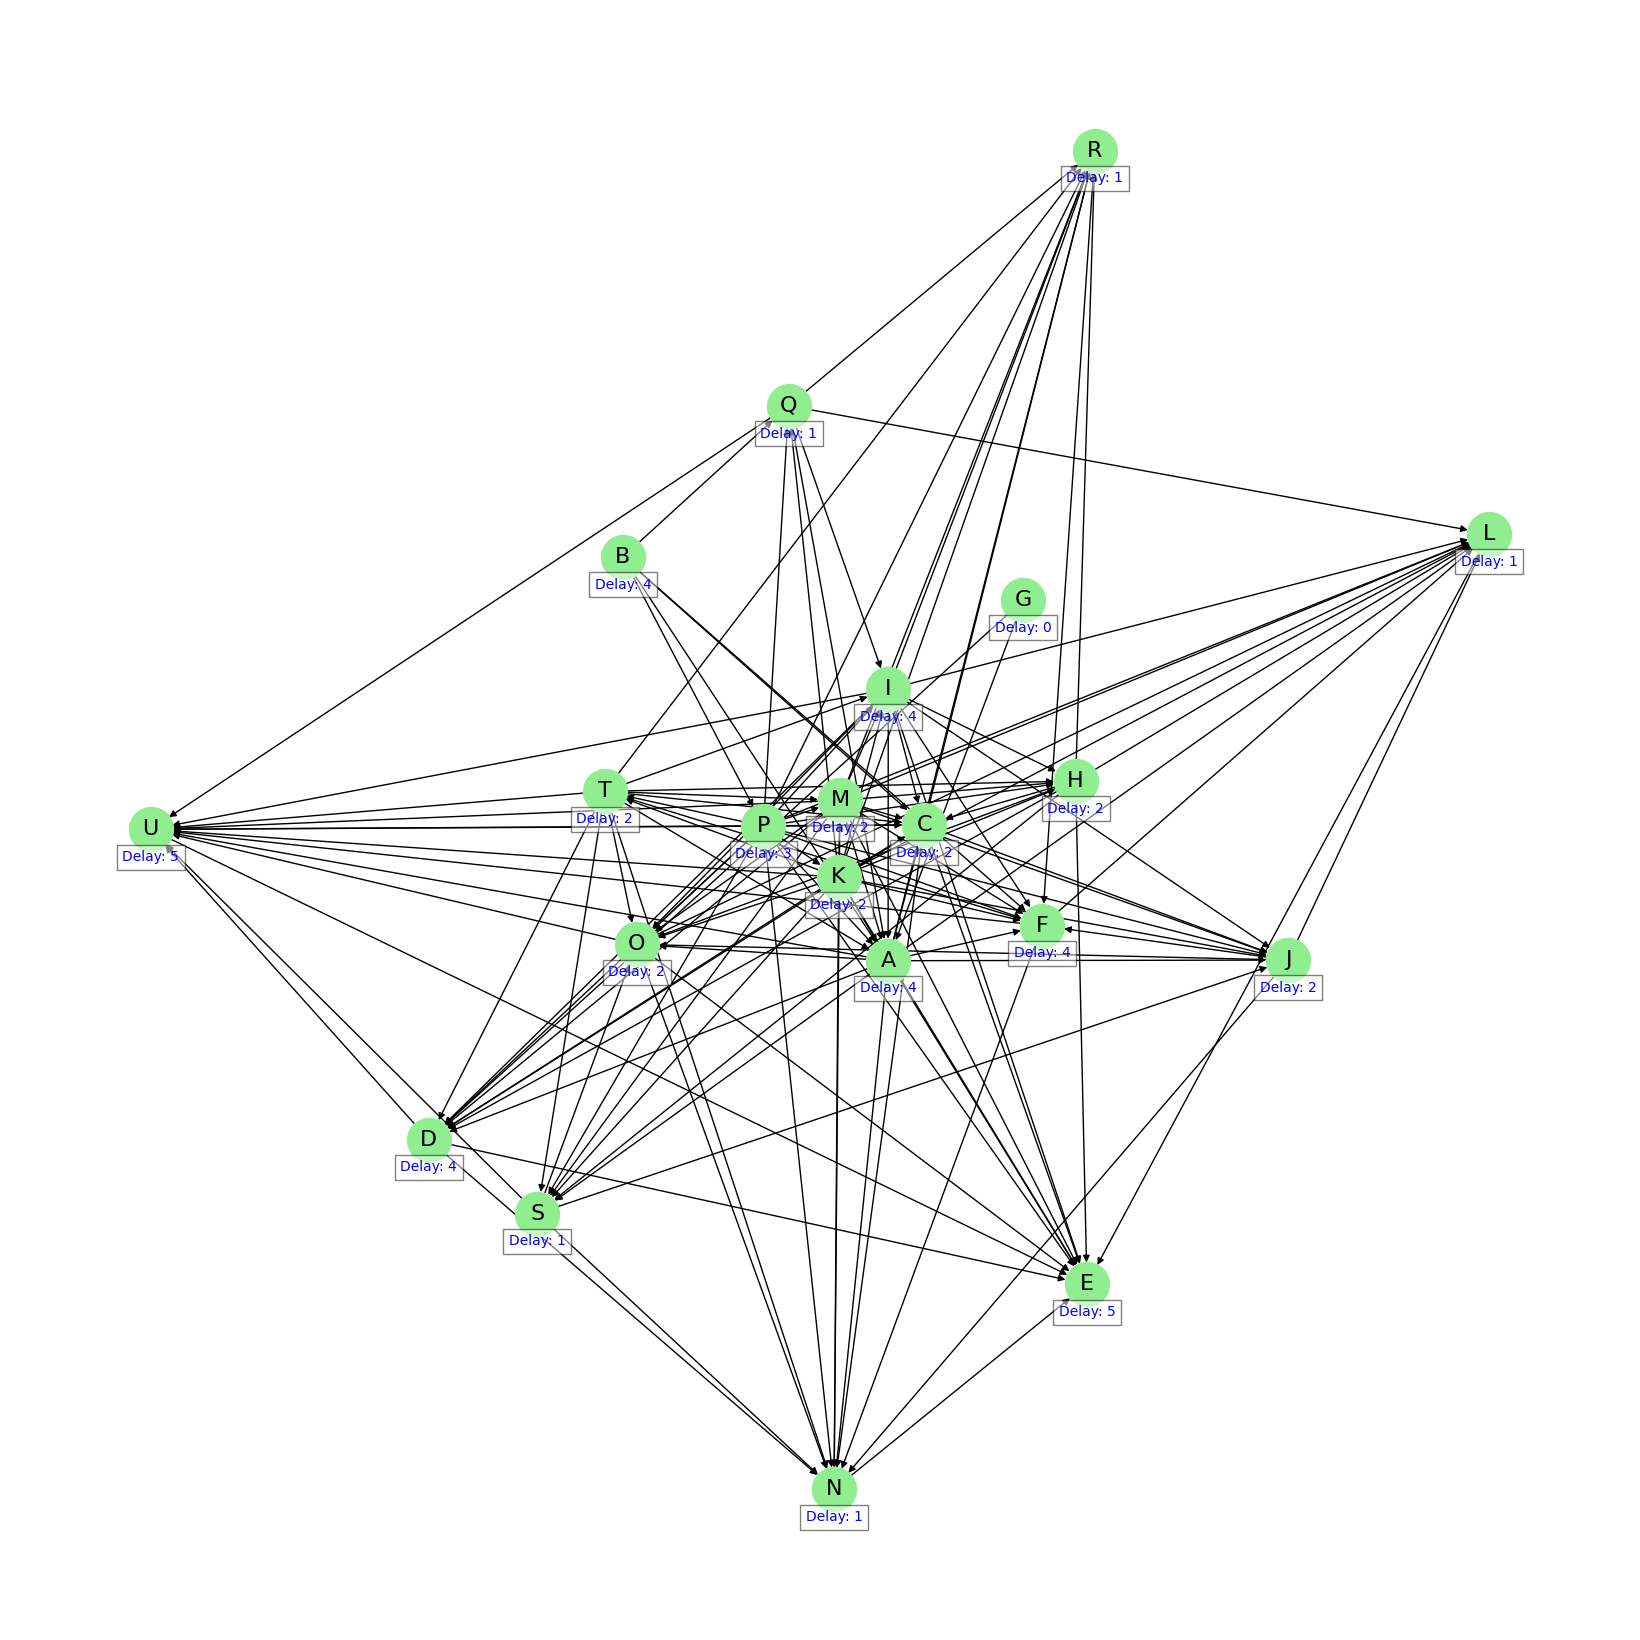

----------------------------------------------
Order: ['J', 'I', 'Q', 'H', 'N', 'C', 'K', 'A', 'U', 'S', 'E', 'P', 'L', 'M', 'D', 'V', 'F', 'R', 'B', 'G', 'O', 'T'], finish_time: 39


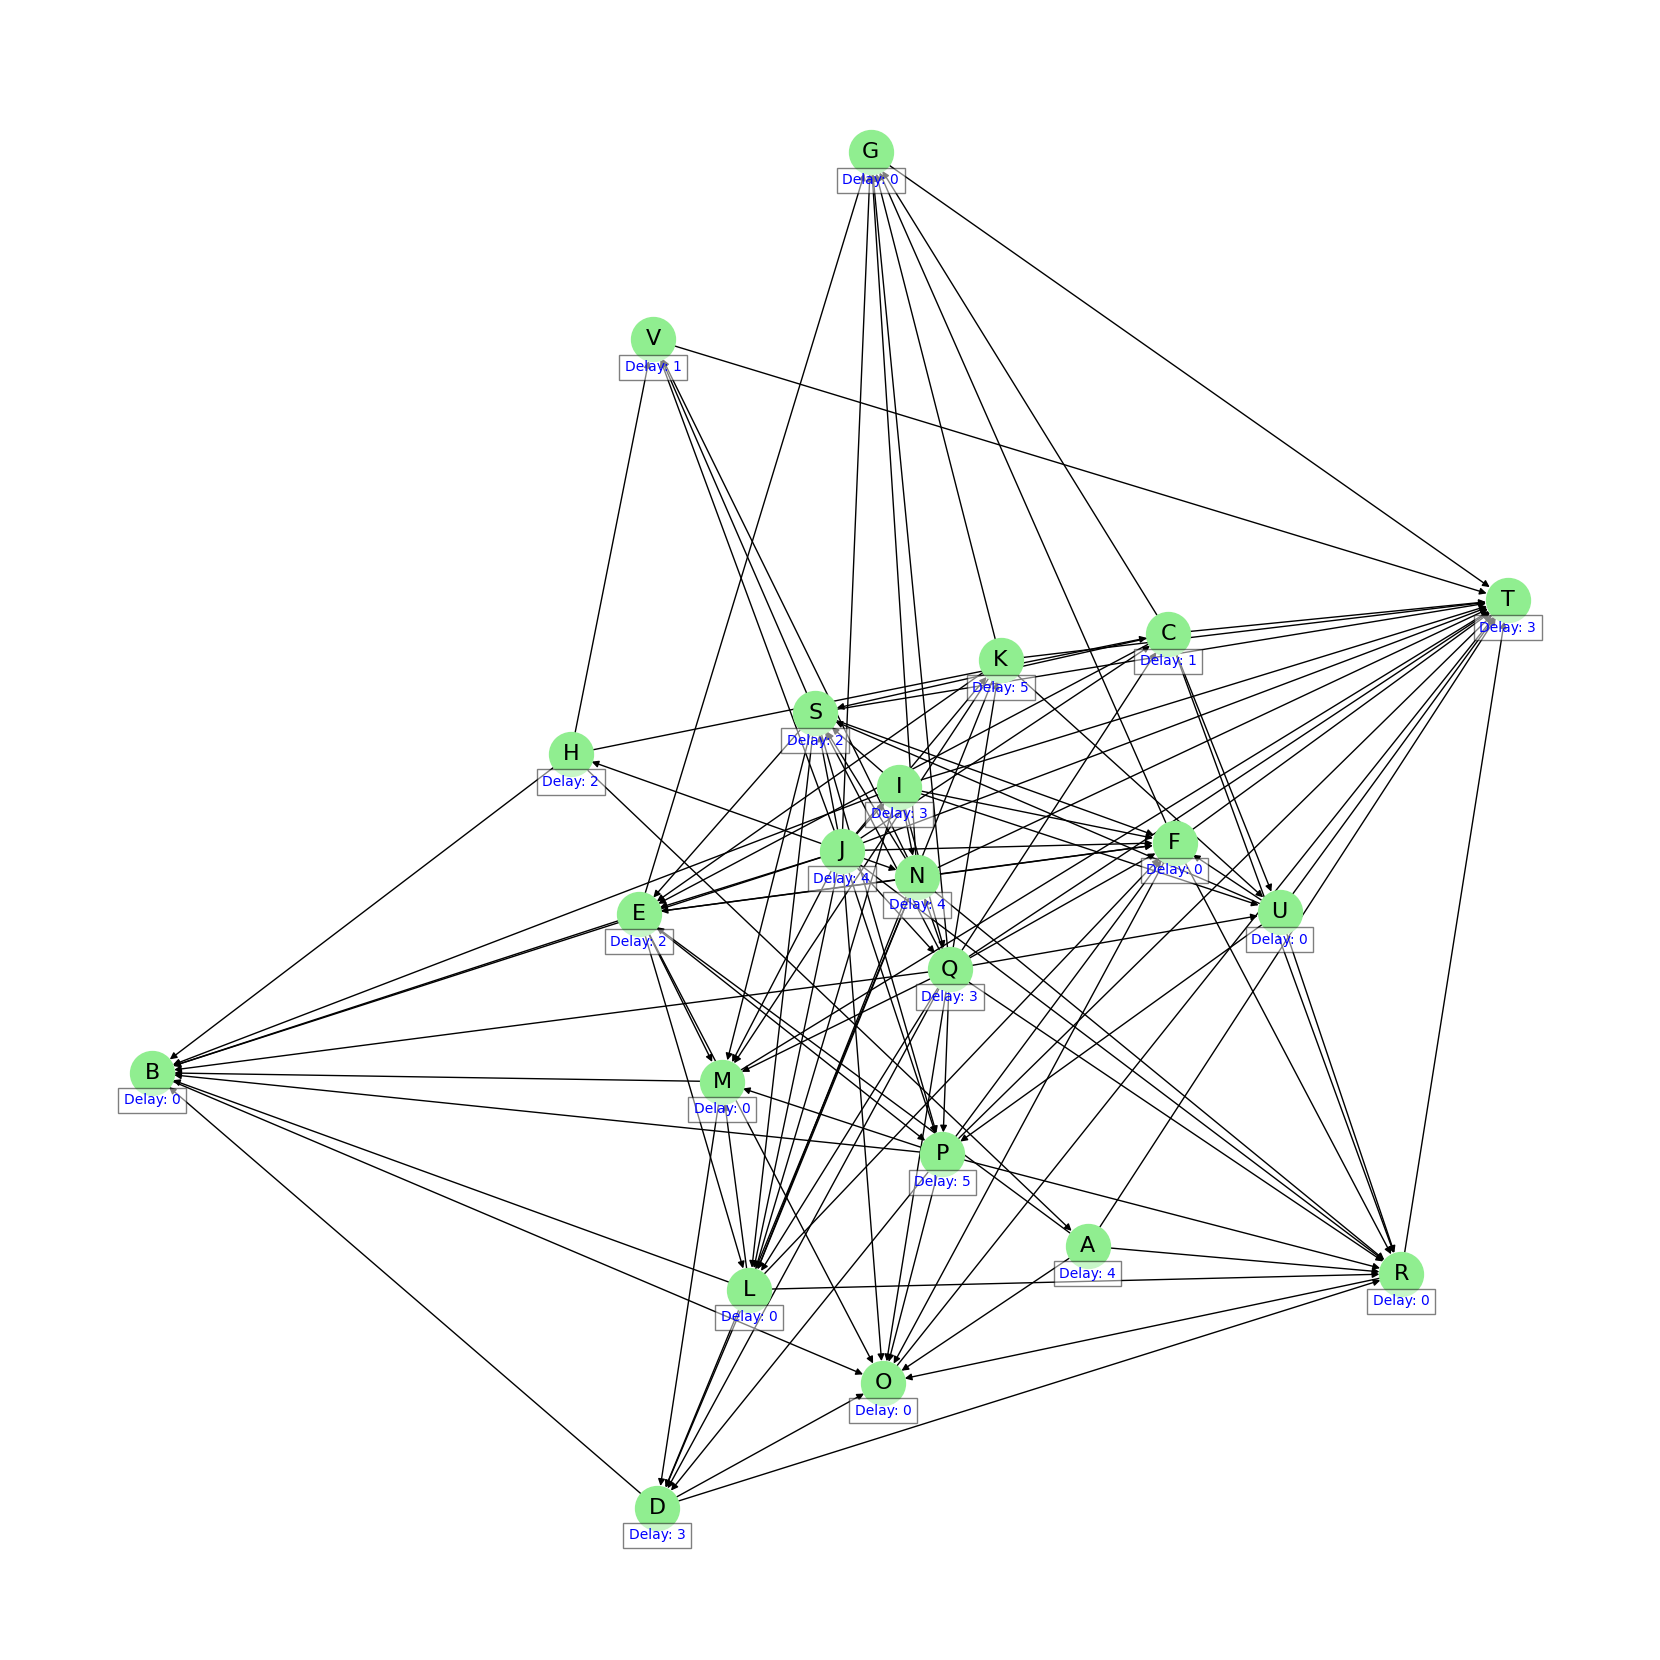

----------------------------------------------
Order: ['N', 'J', 'C', 'S', 'K', 'W', 'H', 'B', 'A', 'G', 'L', 'D', 'Q', 'V', 'P', 'I', 'O', 'E', 'U', 'T', 'M', 'F', 'R'], finish_time: 44


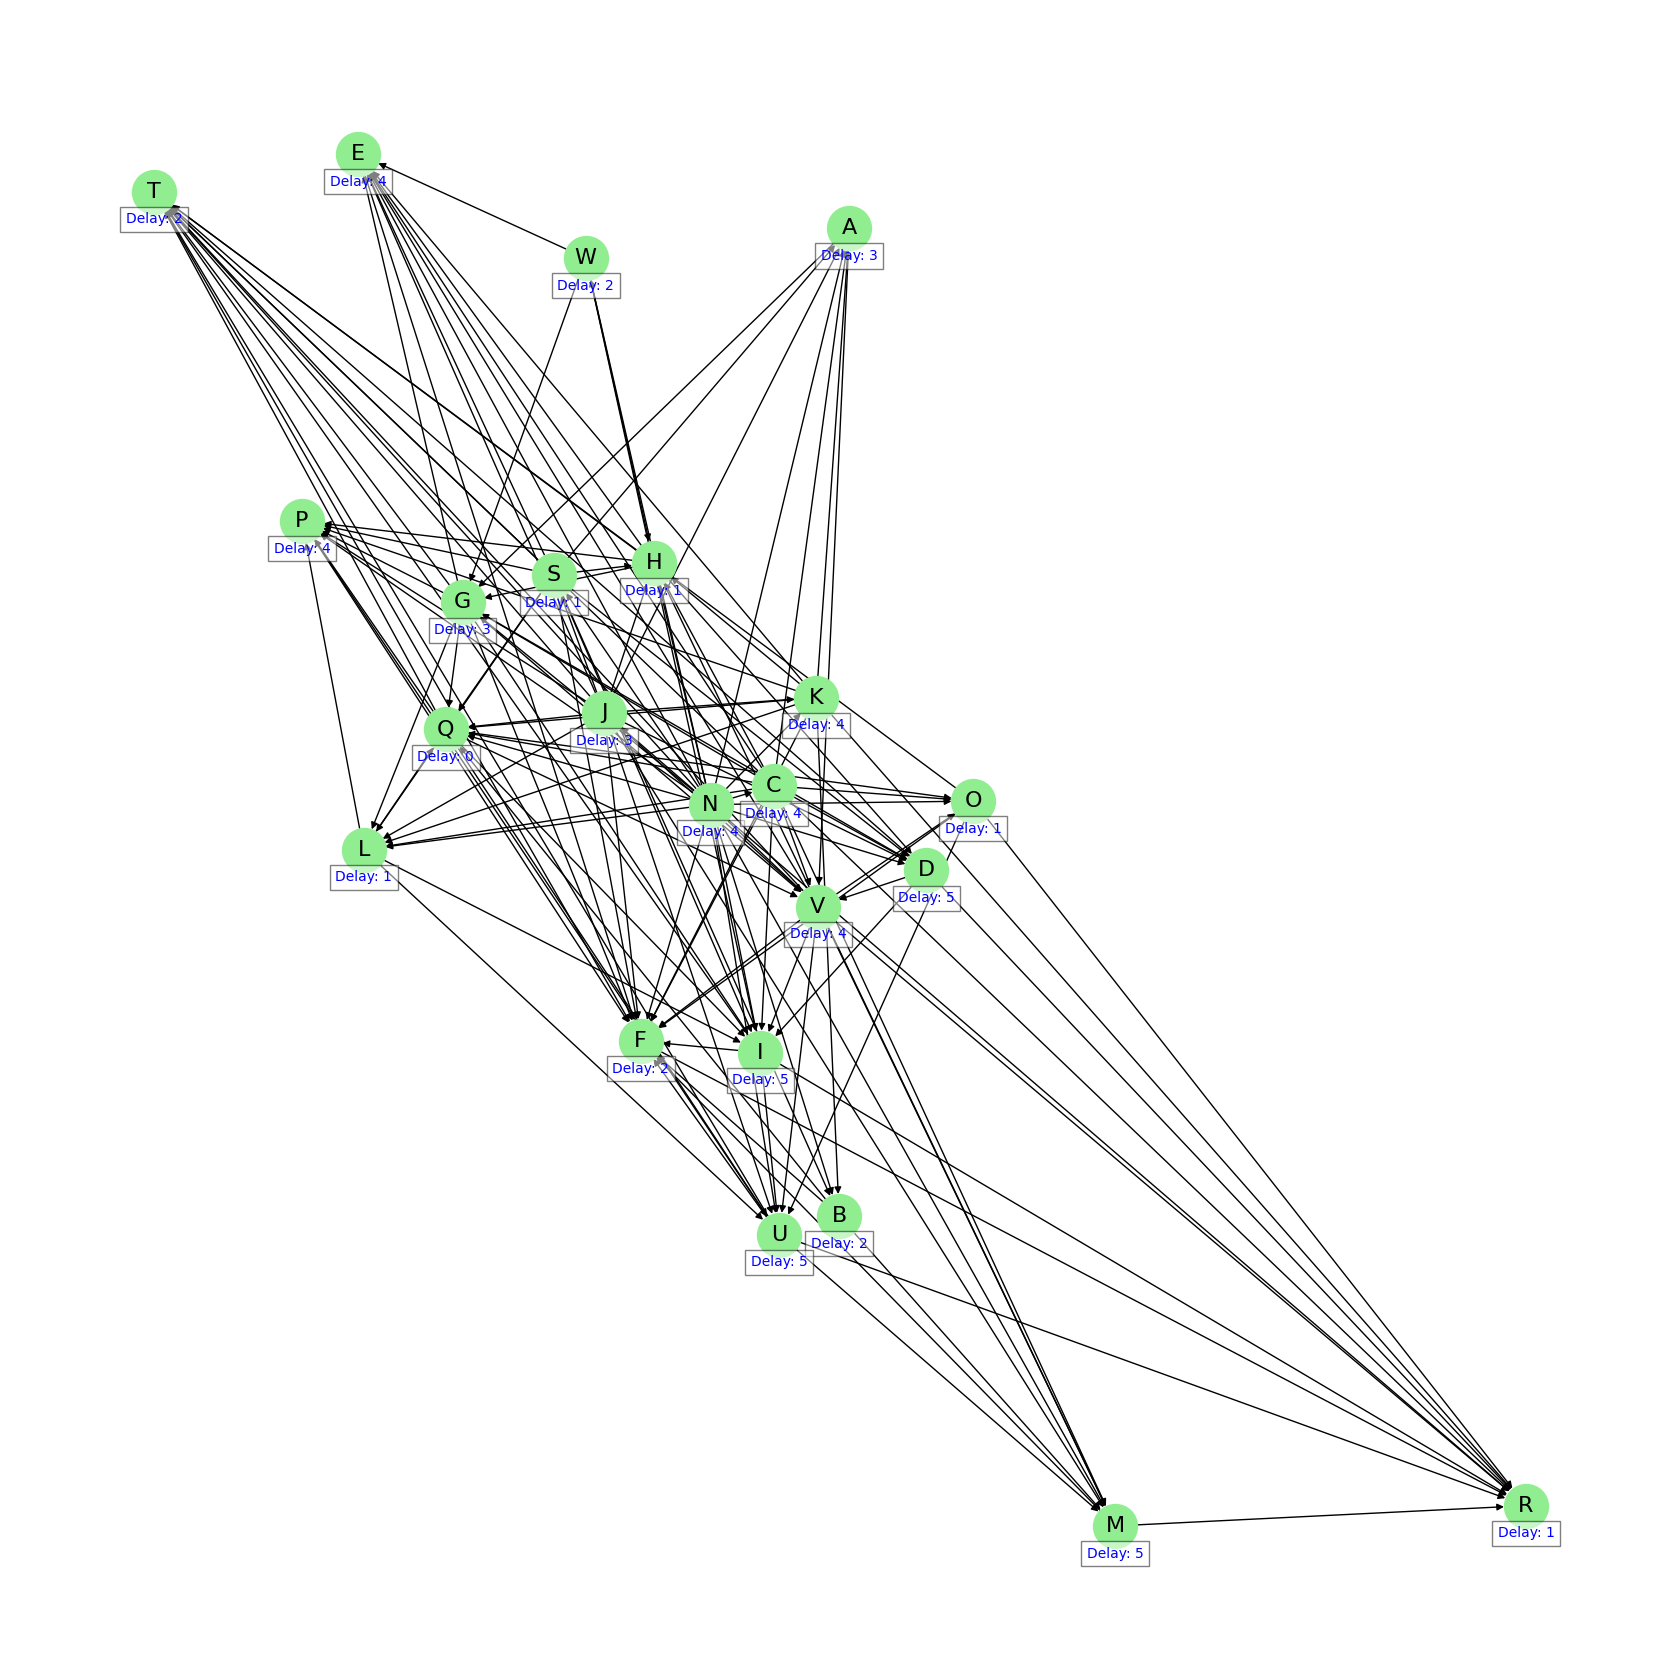

----------------------------------------------
Order: ['H', 'I', 'W', 'F', 'R', 'D', 'Q', 'G', 'U', 'O', 'C', 'P', 'V', 'X', 'B', 'K', 'T', 'J', 'E', 'S', 'M', 'A', 'N', 'L'], finish_time: 57


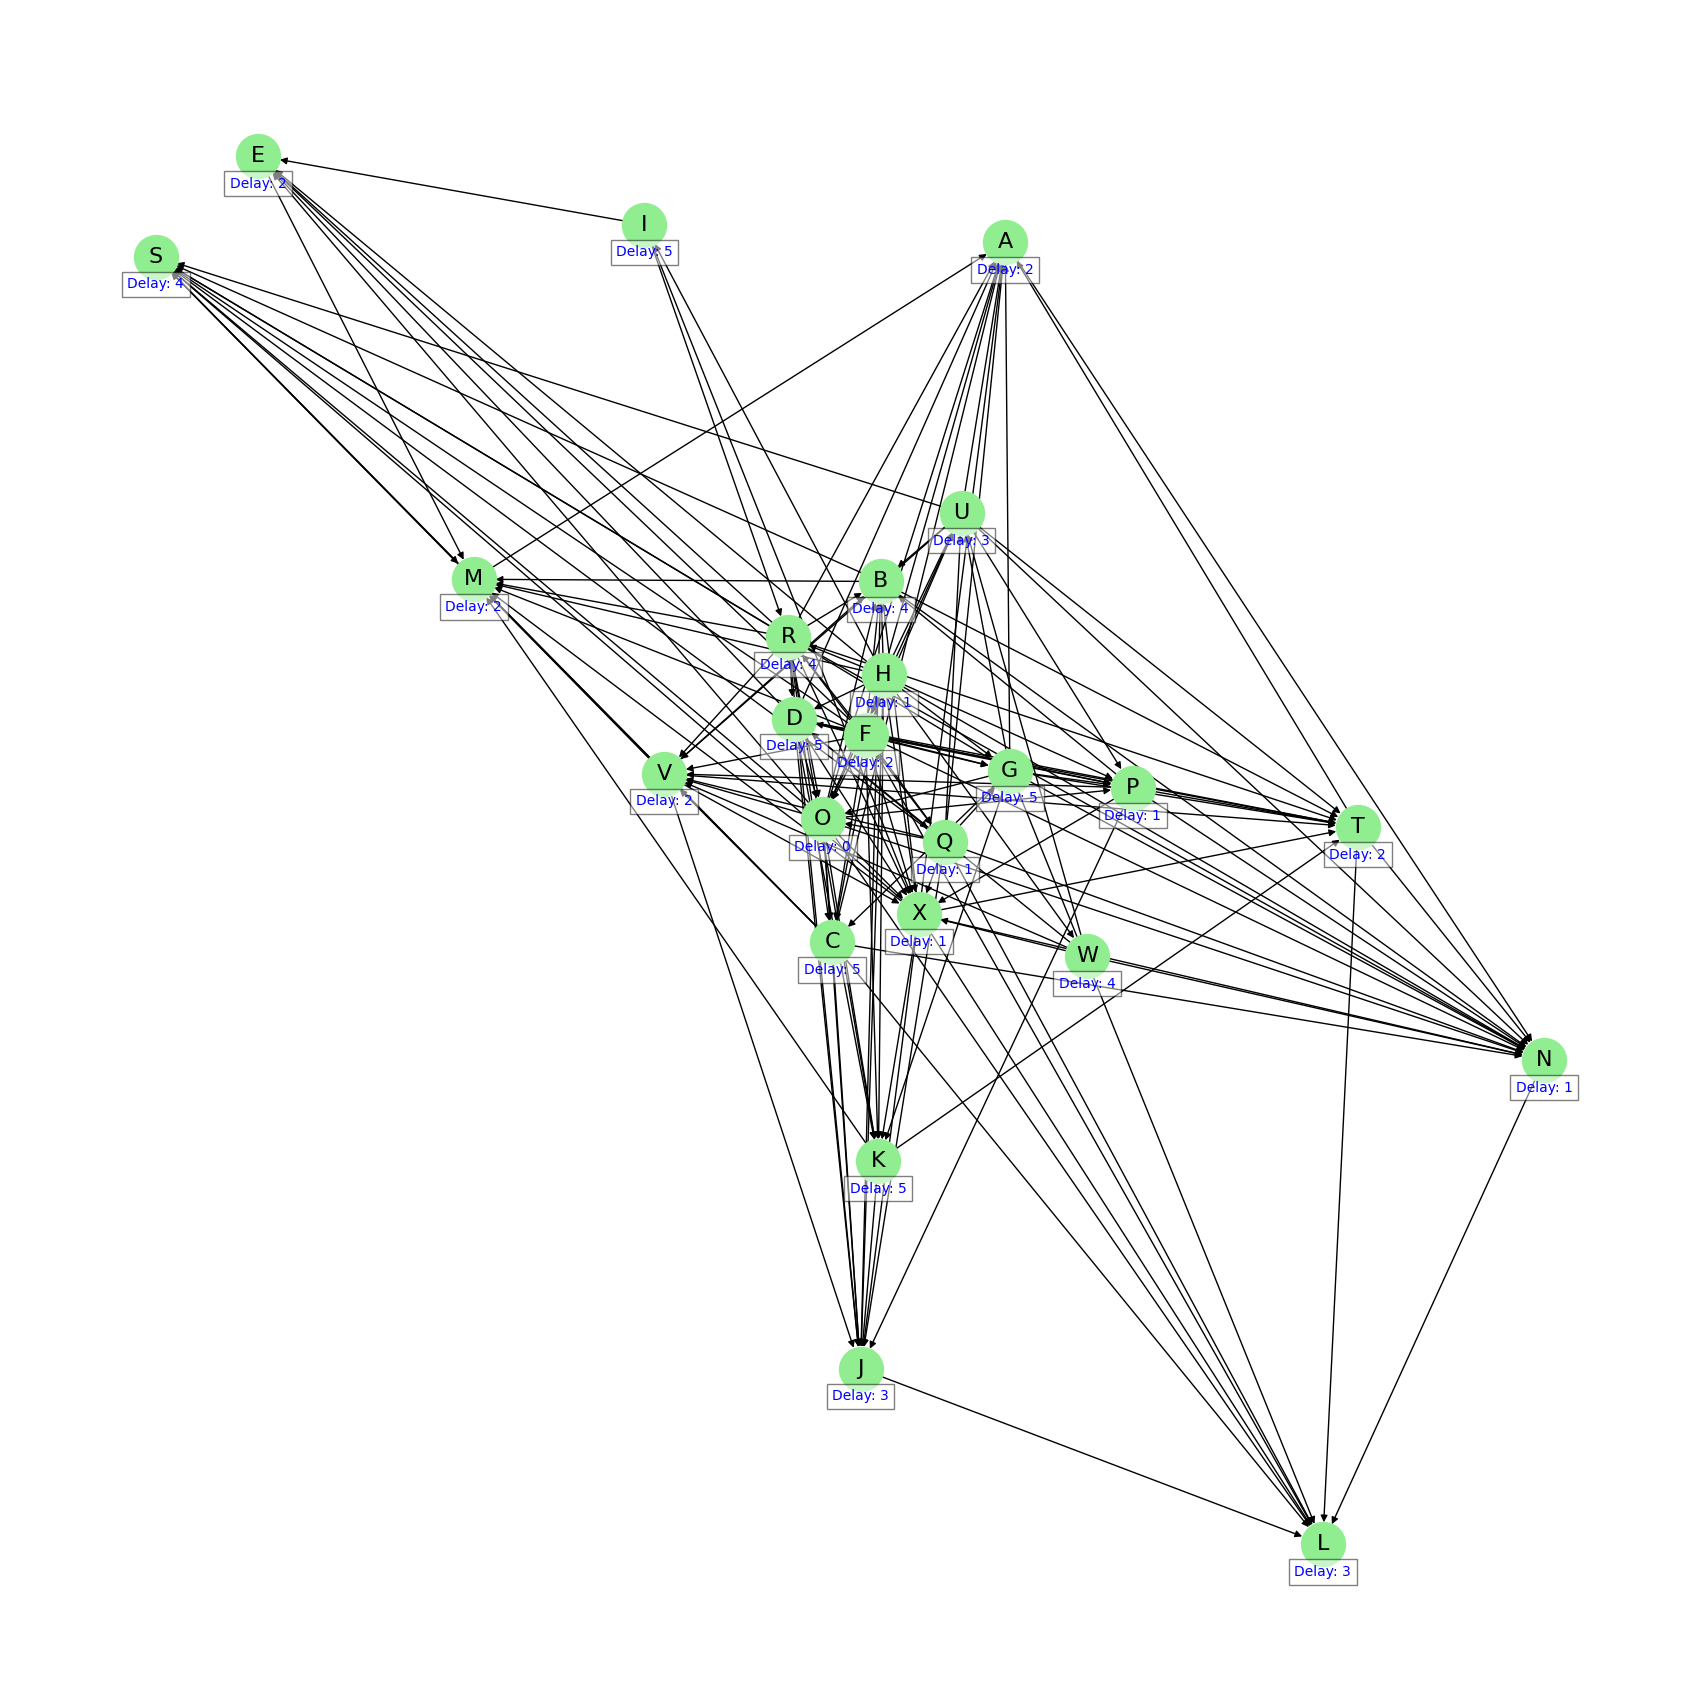

----------------------------------------------
Data saved to <_io.TextIOWrapper name='/home/pavle/Desktop/RI/RI_projekat/MPCSD/results/big_data/SA.json' mode='w' encoding='UTF-8'>


In [77]:
test_file = '/home/pavle/Desktop/RI/RI_projekat/MPCSD/test_files/big_data/'
result_file = '/home/pavle/Desktop/RI/RI_projekat/MPCSD/results/big_data/SA.json'
test_alg(test_file, result_file, simulatedAnnealing, True)